<a href="https://colab.research.google.com/github/rudradeep22/BeyondTheBuzz-Assignment1/blob/main/BYB_A_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from tqdm import tqdm
from sklearn import metrics

In [66]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
path='/content/drive/MyDrive/IMDB Dataset.csv'
data = pd.read_csv(path)
print(len(data))
data.head(5)

50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [70]:
X = data.head(1000).get('review')
y0 = data.head(1000).get('sentiment')
review_list = []
y = []
for review in X:
    review_list.append(review)
review_list[0]
for sentiment in y0:
    if sentiment == 'positive':
        y.append(1)
    else:
        y.append(0)
y = torch.tensor(y, dtype=torch.float32, requires_grad=True)

In [71]:
processed_reviews =[]
vocab = []
for review in tqdm(review_list):
    review = review.lower()
    words = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    filtered_words = [w for w in words if not w in stop_words]
    stemmed_words = []
    for word in words:
        stem_word = ps.stem(word)
        stemmed_words.append(stem_word)
        if stem_word not in vocab:
          vocab.append(stem_word)
    processed_reviews.append(stemmed_words)

100%|██████████| 1000/1000 [00:14<00:00, 68.06it/s]


In [72]:
vocab

['one',
 'of',
 'the',
 'other',
 'review',
 'ha',
 'mention',
 'that',
 'after',
 'watch',
 'just',
 '1',
 'oz',
 'episod',
 'you',
 "'ll",
 'be',
 'hook',
 '.',
 'they',
 'are',
 'right',
 ',',
 'as',
 'thi',
 'is',
 'exactli',
 'what',
 'happen',
 'with',
 'me.',
 '<',
 'br',
 '/',
 '>',
 'first',
 'thing',
 'struck',
 'me',
 'about',
 'wa',
 'it',
 'brutal',
 'and',
 'unflinch',
 'scene',
 'violenc',
 'which',
 'set',
 'in',
 'from',
 'word',
 'go',
 'trust',
 'not',
 'a',
 'show',
 'for',
 'faint',
 'heart',
 'or',
 'timid',
 'pull',
 'no',
 'punch',
 'regard',
 'to',
 'drug',
 'sex',
 'hardcor',
 'classic',
 'use',
 'word.',
 'call',
 'nicknam',
 'given',
 'oswald',
 'maximum',
 'secur',
 'state',
 'penitentari',
 'focus',
 'mainli',
 'on',
 'emerald',
 'citi',
 'an',
 'experiment',
 'section',
 'prison',
 'where',
 'all',
 'cell',
 'have',
 'glass',
 'front',
 'face',
 'inward',
 'so',
 'privaci',
 'high',
 'agenda',
 'em',
 'home',
 'mani',
 '..',
 'aryan',
 'muslim',
 'gangsta

In [131]:
class ReviewClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ReviewClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, 100)
        self.lstm = nn.LSTM(100, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, X):
        hidden_states = torch.zeros(self.num_layers, self.hidden_size)
        cell_states = torch.zeros(self.num_layers,  self.hidden_size)
        embedding = self.embedding(X)
        out, _ = self.lstm(embedding, (hidden_states, cell_states))
        out = out.view(-1, self.hidden_size)
        out = self.linear(out)
        out = out.max().view(-1)
        out = torch.sigmoid(out)
        return out

In [141]:
input_size = len(vocab)
hidden_size = 128
num_layers = 2
learning_rate = 0.001
num_epochs = 1


In [139]:
model = ReviewClassifier(input_size, hidden_size, num_layers)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

ReviewClassifier(
  (embedding): Embedding(15269, 100)
  (lstm): LSTM(100, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [76]:
dict_word_to_int = {word:i for i,word in enumerate(vocab)}

In [77]:
training_list=[]
for review in processed_reviews:
  training_sentence = [dict_word_to_int[word] for word in review]
  training_list.append(training_sentence)

In [142]:
losses = []

for epoch in range(num_epochs):
  for i,training_sentence in enumerate(training_list):
      model.train()
      training_tensor = torch.tensor(training_sentence, dtype=torch.int64)
      optimizer.zero_grad()
      y_pred = model(training_tensor)
      loss = criterion(y_pred,y[i].view(-1))
      losses.append(loss)
      loss.backward()
      optimizer.step()
      print(f'Epoch: {epoch+1}, Step: {i+1}, Loss: {loss}')

Epoch: 1, Step: 1, Loss: 0.7077556252479553
Epoch: 1, Step: 2, Loss: 0.7089753150939941
Epoch: 1, Step: 3, Loss: 0.7085475921630859
Epoch: 1, Step: 4, Loss: 0.6853768229484558
Epoch: 1, Step: 5, Loss: 0.6968263387680054
Epoch: 1, Step: 6, Loss: 0.6804996132850647
Epoch: 1, Step: 7, Loss: 0.6958453059196472
Epoch: 1, Step: 8, Loss: 0.7089555859565735
Epoch: 1, Step: 9, Loss: 0.7200164794921875
Epoch: 1, Step: 10, Loss: 0.7066255211830139
Epoch: 1, Step: 11, Loss: 0.7077336311340332
Epoch: 1, Step: 12, Loss: 0.7077513933181763
Epoch: 1, Step: 13, Loss: 0.7036592960357666
Epoch: 1, Step: 14, Loss: 0.7072287797927856
Epoch: 1, Step: 15, Loss: 0.7055819034576416
Epoch: 1, Step: 16, Loss: 0.7045599222183228
Epoch: 1, Step: 17, Loss: 0.6811896562576294
Epoch: 1, Step: 18, Loss: 0.696933388710022
Epoch: 1, Step: 19, Loss: 0.6919506788253784
Epoch: 1, Step: 20, Loss: 0.6963104009628296
Epoch: 1, Step: 21, Loss: 0.6909825205802917
Epoch: 1, Step: 22, Loss: 0.6966937184333801
Epoch: 1, Step: 23, 

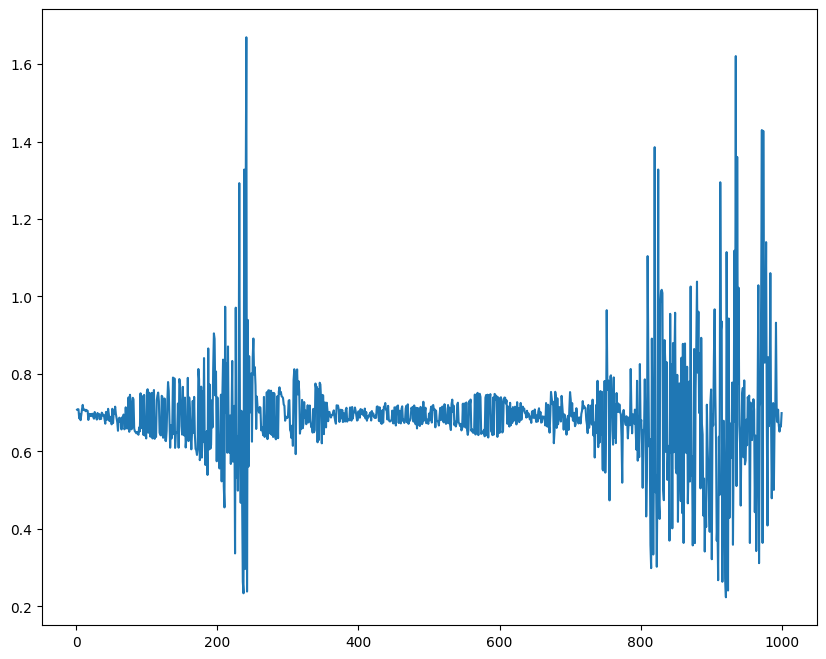

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
l = len(losses)
plot_losses=[]
for loss in losses:
  plot_losses.append(loss.detach().numpy())
plt.plot(range(1, l+1), plot_losses)
plt.show()